##### Segment Anything Model (SAM) for Lunar Maria Detection

■ references
- https://tt-tsukumochi.com/archives/7409

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import supervision as sv

import sys
sys.path.append('/workspace/home/azuma/Personal_Projects/github/segment-anything')
from segment_anything import SamPredictor, sam_model_registry
from segment_anything import SamAutomaticMaskGenerator


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

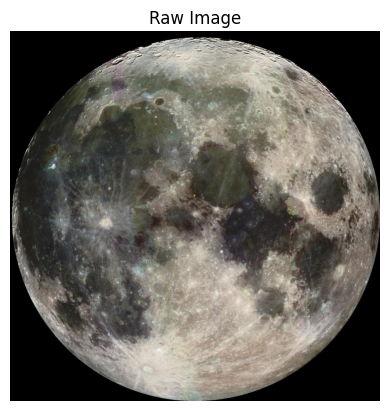

In [4]:
# load image
IMAGE_PATH = '/workspace/home/azuma/Personal_Projects/github/Moon_Pattern_Inference/images/raw_image.jpg'

image = Image.open(IMAGE_PATH).convert("RGB")
image = image.resize((1024, 1024), Image.LANCZOS) # resize
image = np.array(image)

plt.imshow(image)
plt.title("Raw Image")
plt.axis("off") 
plt.show()

RGB以外にもLAやLを指定することでグレースケールにもできる。

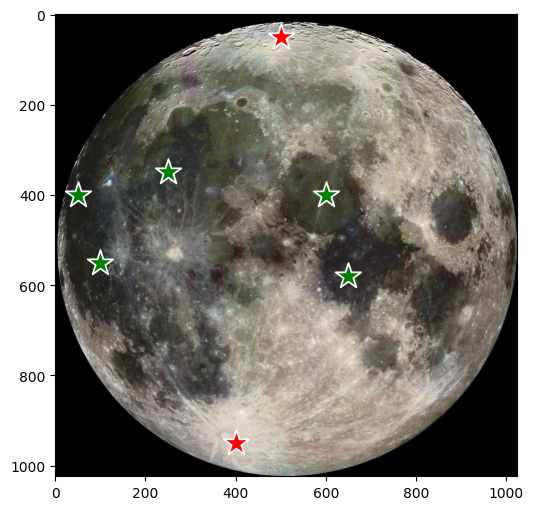

In [5]:
# sam preparation
sam = sam_model_registry["vit_h"](checkpoint="/workspace/home/azuma/Personal_Projects/datasource/SAM_Checkpoints/sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam.to(device=DEVICE)

predictor = SamPredictor(sam)
predictor.set_image(image)

input_point = np.array([[250, 350],[50, 400],[600, 400],[650, 580],[100,550],[400,950],[500,50]])
input_label = np.array([1,1,1,1,1,0,0])
plt.figure(figsize=(6,6))
plt.imshow(image,cmap="gray", vmin=0, vmax=255)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  


上の図のように、目的箇所と背景を区別してプロンプトを与えることができる。

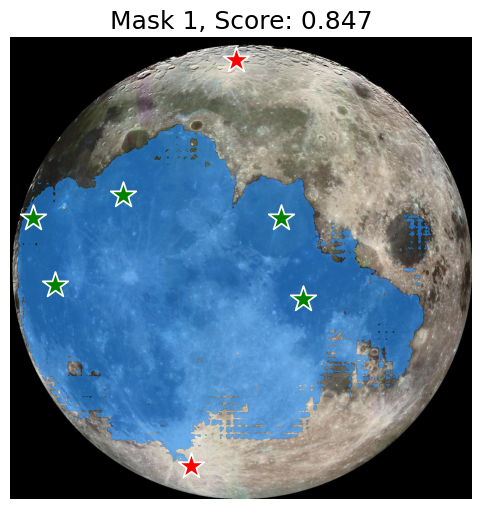

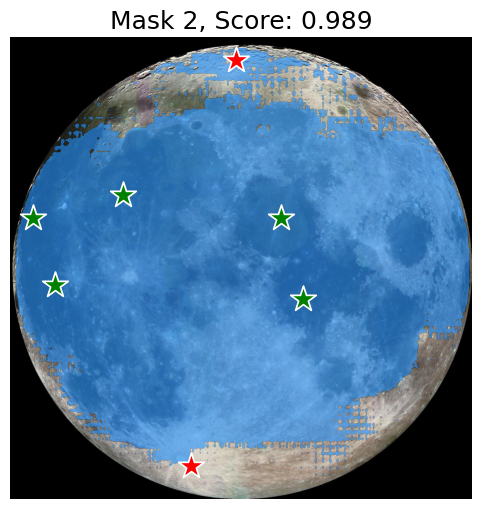

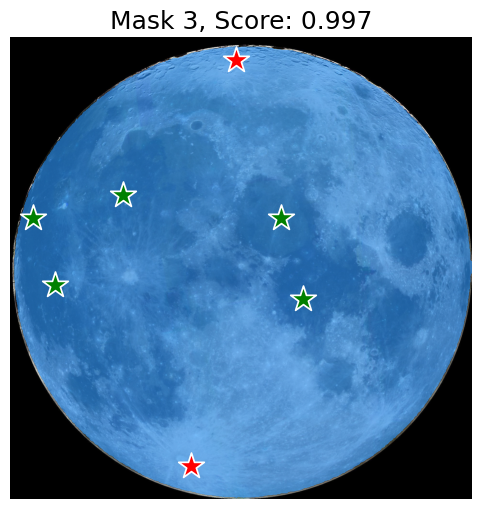

In [6]:
# condut sam
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

月の輪郭は認識できているが、目的のマリアの認識には程遠い。

***
##### 考察
今回うまく認識できなかった原因としていくつか考えられる。
- 取得したチェックポイントとの相性が良くない。
- プロンプトの数が不十分。
- モデルのパラメータチューニング。
- 画像のスケールが大きい。車の窓などのセグメンテーションはできても、大規模で一様な模様を抜くのが難しい？

→ 人間の目からするとそこまで難しいタスクではないため、もっと簡単に認識できると思ったけど...